# Instaling dependancy

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import xgboost as xgb
import numpy as np


In [ ]:
# Plotting settings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Load data
train_df = pd.read_csv('/content/drive/MyDrive/Task_2/Train_data.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Task_2/test_data.csv')

## 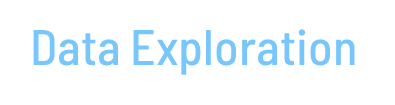

In [ ]:
# Separate features and target variable
X_train = train_df.drop('Disease', axis=1)
y_train = train_df['Disease']
X_test = test_df.drop('Disease', axis=1)
y_test = test_df['Disease']

In [ ]:
# Encode target labels with values between 0 and n_classes-1
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
y_train_encoded = label_encoder.transform(y_train)


# Data Visualization

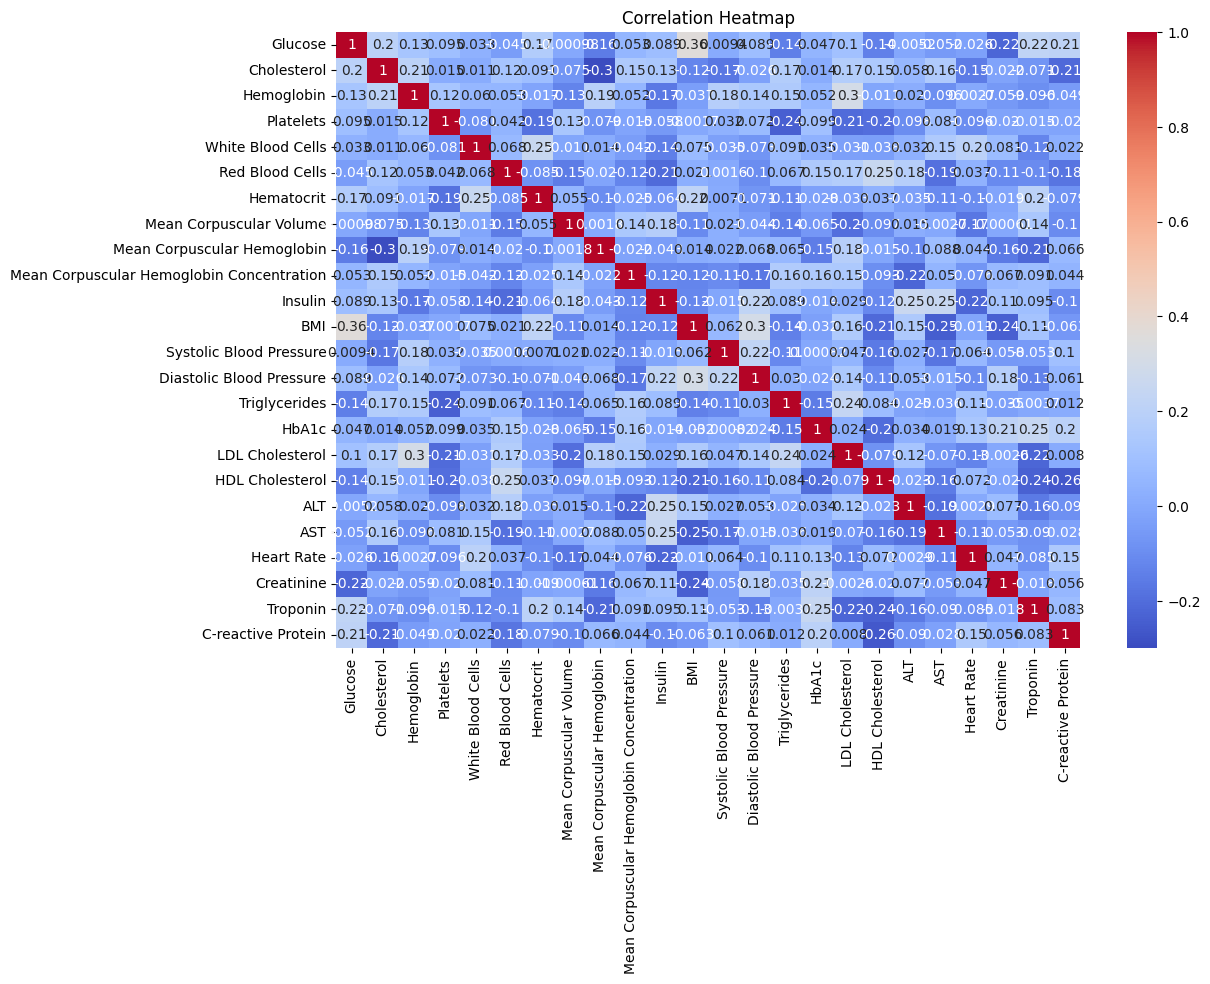

In [ ]:
# Correlation Heatmap
plt.figure(figsize=(12, 8))
correlation_matrix = X_train.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

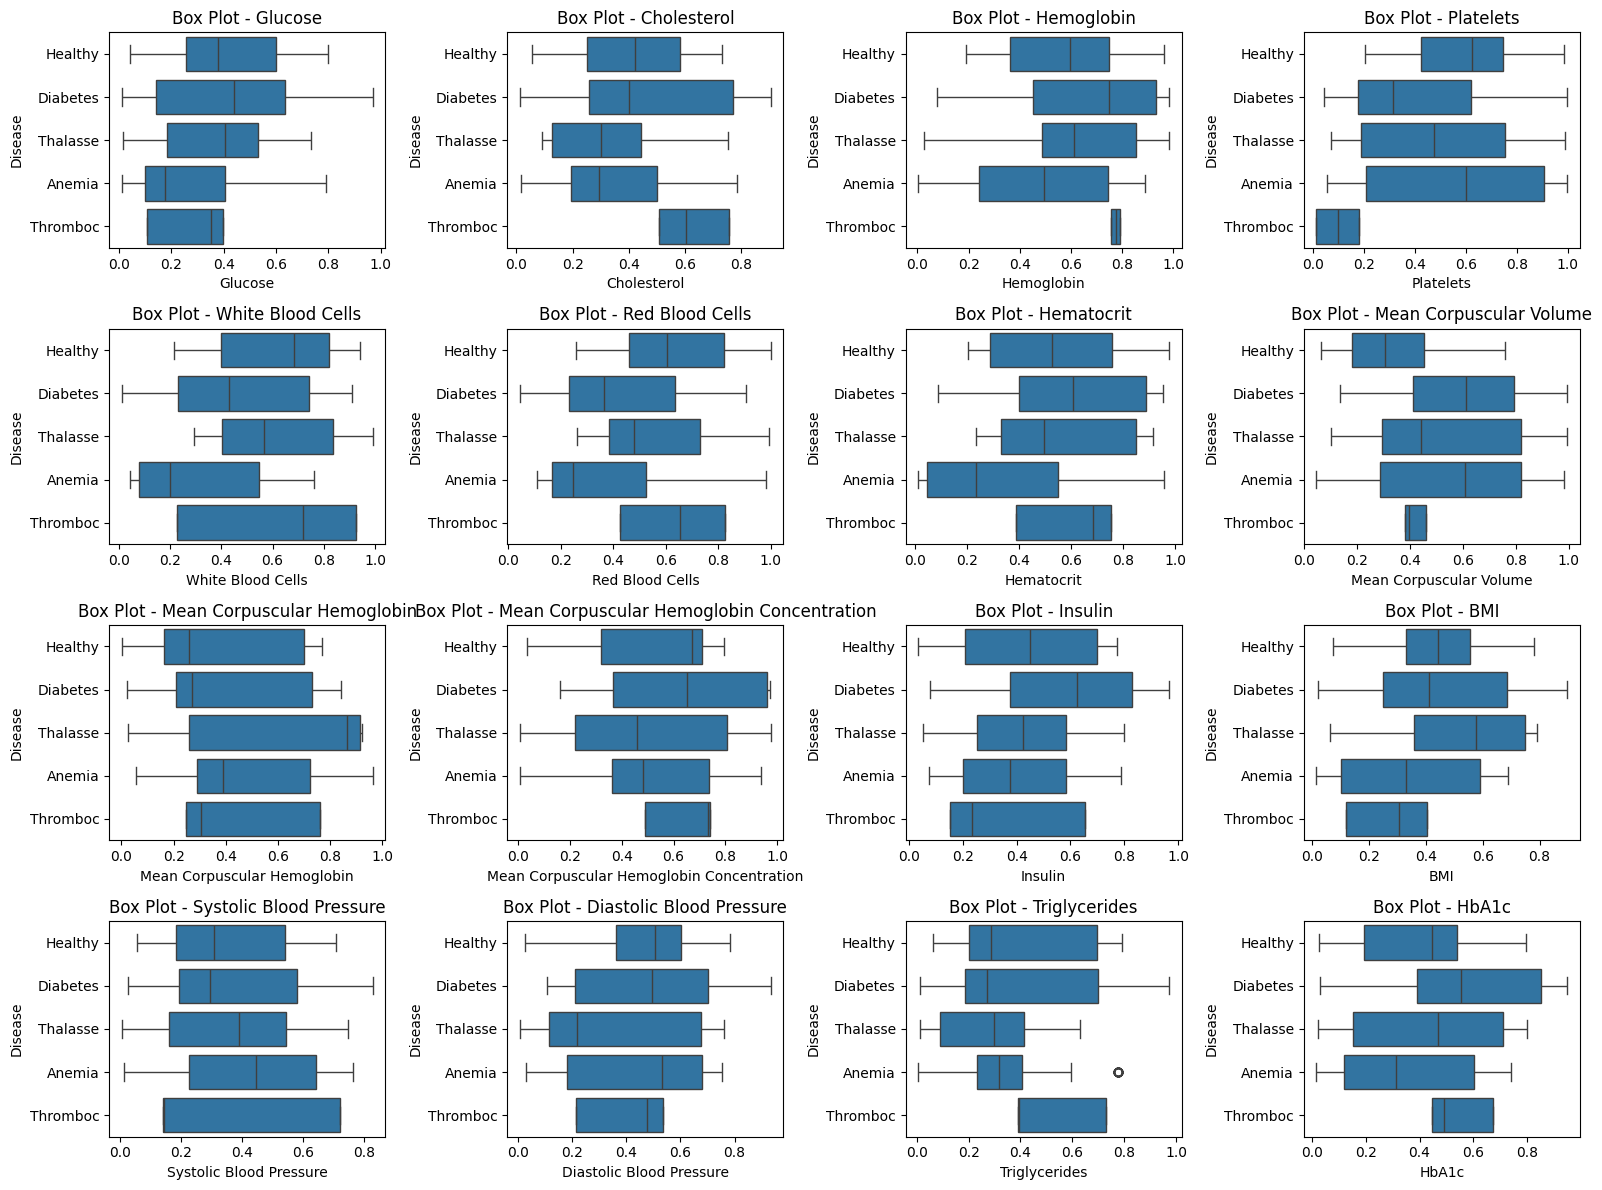

In [ ]:
# Box Plots for each feature
plt.figure(figsize=(16, 12))
for i in range(1, 17):
    plt.subplot(4, 4, i)
    sns.boxplot(data=X_train, x=X_train.columns[i-1], y=y_train)
    plt.title(f'Box Plot - {X_train.columns[i-1]}')
plt.tight_layout()
plt.show()

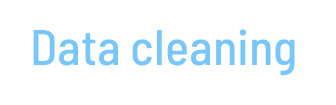

find average values to either remove zero values or replace with the mean value

In [ ]:

# Filter out unseen labels from the test data and ensure alignment
valid_labels_mask = y_test.isin(label_encoder.classes_)
X_test_filtered = X_test[valid_labels_mask]
y_test_filtered = y_test[valid_labels_mask]

# Check lengths after filtering
print("Length of X_test_filtered:", len(X_test_filtered))
print("Length of y_test_filtered:", len(y_test_filtered))

# Encode filtered test labels
# Filter out unseen labels from the test data
X_test_filtered = X_test[y_test.isin(label_encoder.classes_)]
y_test_filtered = y_test[y_test.isin(label_encoder.classes_)]

# Encode filtered test labels
y_test_encoded = label_encoder.transform(y_test_filtered)

Length of X_test_filtered: 447
Length of y_test_filtered: 447


In [ ]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test_filtered)

# Check lengths after scaling
print("Length of X_train_scaled:", len(X_train_scaled))
print("Length of X_test_scaled:", len(X_test_scaled))
print("Length of y_train_encoded:", len(y_train_encoded))
print("Length of y_test_encoded:", len(y_test_encoded))


Length of X_train_scaled: 2351
Length of X_test_scaled: 447
Length of y_train_encoded: 2351
Length of y_test_encoded: 447


In [ ]:
# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0]
}

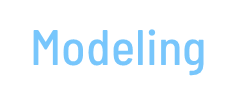

In [ ]:
# Initialize the XGBoost model
xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=len(label_encoder.classes_), random_state=30)

# Perform RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_grid, n_iter=100,
                                   scoring='accuracy', cv=3, verbose=1, random_state=30, n_jobs=-1)

In [ ]:
# Fit the model
random_search.fit(X_train_scaled, y_train_encoded)

# Best parameters
print("Best Parameters:", random_search.best_params_)

# Best model
best_xgb_model = random_search.best_estimator_

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best Parameters: {'subsample': 0.8, 'n_estimators': 400, 'max_depth': 10, 'learning_rate': 0.01, 'colsample_bytree': 0.8}


In [ ]:
# Predictions
y_pred_train_xgb = best_xgb_model.predict(X_train_scaled)
y_pred_test_xgb = best_xgb_model.predict(X_test_scaled)

# Inverse transform the encoded labels back to original labels
y_pred_train_xgb_labels = label_encoder.inverse_transform(y_pred_train_xgb)
y_pred_test_xgb_labels = label_encoder.inverse_transform(y_pred_test_xgb)

In [ ]:
print("Length of y_test_filtered:", len(y_test_filtered))
print("Length of y_pred_test_xgb_labels:", len(y_pred_test_xgb_labels))

Length of y_test_filtered: 447
Length of y_pred_test_xgb_labels: 447


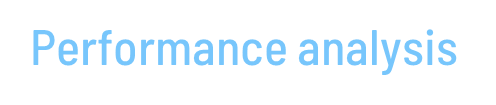

XGBoost Model Performance:
Training Accuracy: 1.0
Test Accuracy: 0.4451901565995526

Confusion Matrix:
[[ 49  22   7   6   0]
 [ 92 124  36  35   7]
 [  0   0   5   0   0]
 [  0  20   9  18   1]
 [  2   9   2   0   3]]

Classification Report:
              precision    recall  f1-score   support

      Anemia       0.34      0.58      0.43        84
    Diabetes       0.71      0.42      0.53       294
     Healthy       0.08      1.00      0.16         5
    Thalasse       0.31      0.38      0.34        48
    Thromboc       0.27      0.19      0.22        16

    accuracy                           0.45       447
   macro avg       0.34      0.51      0.34       447
weighted avg       0.57      0.45      0.47       447



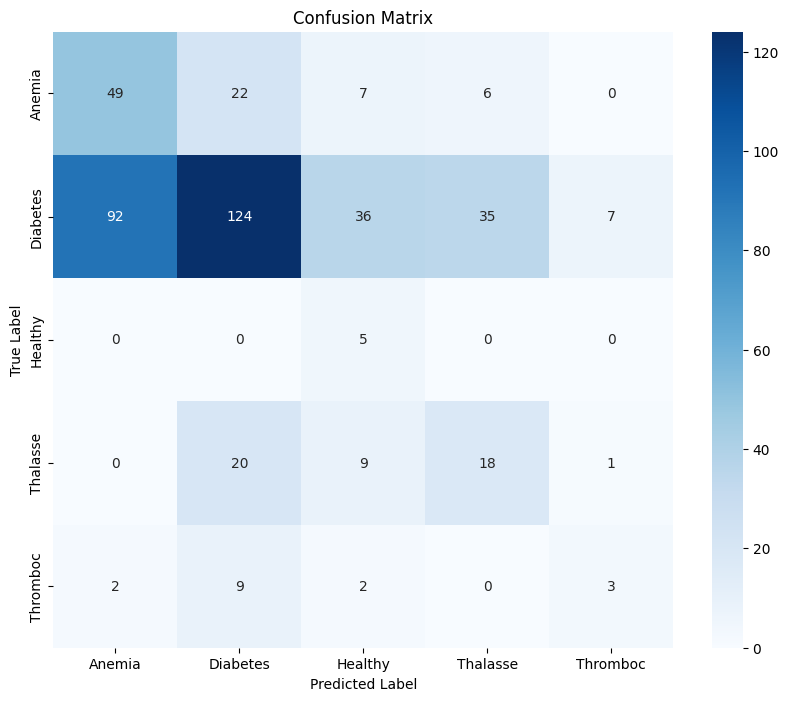

In [ ]:
# Performance metrics
print("XGBoost Model Performance:")
print("Training Accuracy:", accuracy_score(y_train, y_pred_train_xgb_labels))
print("Test Accuracy:", accuracy_score(y_test_filtered, y_pred_test_xgb_labels))

print("\nConfusion Matrix:")
conf_matrix = confusion_matrix(y_test_filtered, y_pred_test_xgb_labels)
print(conf_matrix)

print("\nClassification Report:")
print(classification_report(y_test_filtered, y_pred_test_xgb_labels))

# Visualization
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()